# Определение стоимости автомобилей

**Цель исследования:** 
Построить модeль для определения стоимости автомобиля с пробегом для сервиса по продаже автомобилей с пробегом. Сервис разрабатывает приложение для привлечения новых клиентов для быстрой оценки рыночной стоимости своего автомобиля.  

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки**   

-	DateCrawled — дата скачивания анкеты из базы
-	VehicleType — тип автомобильного кузова
-	RegistrationYear — год регистрации автомобиля
-	Gearbox — тип коробки передач
-	Power — мощность (л. с.)
-	Model — модель автомобиля
-	Kilometer — пробег (км)
-	RegistrationMonth — месяц регистрации автомобиля
-	FuelType — тип топлива
-	Brand — марка автомобиля
-	Repaired — была машина в ремонте или нет
-	DateCreated — дата создания анкеты
-	NumberOfPictures — количество фотографий автомобиля
-	PostalCode — почтовый индекс владельца анкеты (пользователя)
-	LastSeen — дата последней активности пользователя

**Целевой признак**. 

- Price — цена (евро)


## Подготовка данных

 #### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import random
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb


STATE = RandomState(12345)

#### Изучение данных 

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
print('Количество пропусков', df.isna().sum())

Количество пропусков DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [7]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 4


In [8]:
# Избавимся от дубликатов
df = df.drop_duplicates()
df.duplicated().sum()

0

**Первичный анализ:**

- В данных 354365 строк и 16 столбцов.
- Сразу видно, что присутствуют неинформативные для нашей цели призаки (определение стоимости автомобиля), которые не могут влиять на рыночную стоимость. Например, дата создания объявления или наличие фотографий не могут влиять на скорость продажи машины.
- Присутствуют пропуски и аномальные значения:
    - В столбце Price минимальное значение 0
    - В столбце RegistrationYear есть некорректные значения года регистрации
    - В столбце Power есть некорректные значения мощности двигателя
    - В столбце RegistrationMonth отсутсвует месяц регистрации
    - В столбце Kilometer более 50% с пробегом 150 000    
- с типами данных все в порядке

#### Предобработка

**Перечислим призаки, которые будем считать информативными (влияющими на стоимость автомобиля и соотвественно значимыми для модели:**

- VehicleType. Тип машины определяет ее функционал.

- RegistrationYear. Год регистрации определяет "свежесть" машины. 

- Gearbox. Наличие автоматической коробки передач в подавляющем большинстве повышает стоимость машины и в любом случе влияет на стоимость.

- Power. Мощность в лошадиных силах напрямую влияет на стоимость.

- Model. Влияет на стоимость.

- Kilometer. При прочих равных, чем больше пробег, тем меньше стоимость.

- FuelType. Тип топлива определяет конструкцию двигателя.

- Brand. Указание компании-производителя непосредественно влияет на стоимость.

- NotRepaired. Если машина побывала в ДТП, то ее стоимость понижается.

In [9]:
# Удалим призаки, которые считаем не информативными.
del df['DateCrawled'], df['DateCreated'], df['NumberOfPictures'], df['PostalCode'], df['LastSeen']

In [10]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [11]:
# Посмотрим на интересующие нас данные
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


In [12]:
# Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [13]:
# Сделаем названия столбцов более читаемыми
df = df.rename(columns = {'vehicletype': 'vehicle_type',
                     'registrationyear': 'registration_year', 
                     'registrationmonth': 'registration_month', 
                     'gearbox': 'gear_box', 
                     'fueltype': 'fuel_type'
                    })

In [14]:
df.head(2)

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes


Поработаем с пропусками

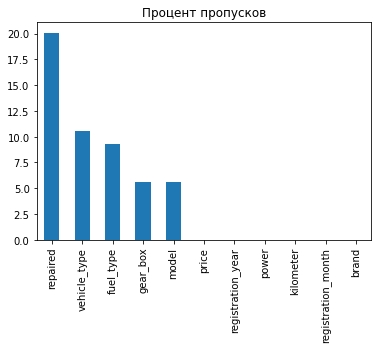

In [15]:
(df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100).plot(kind='bar', title = 'Процент пропусков')
plt.show()

Объем пропущенных значений:

- 20% в столбце repaired. Возможно, здесь пропуски из-за человеческого фактора, автомобиль не был в ремонте и владельцы пропустили это значение. Либо решили скрыть факт повреждения.
- 11% в столбце vehicle_type.	
- 10% в cтолбце fuel_type.
- 6% в столбце model
- 6% в столбце gear_box

Природа пропусков в остальных столбцах не известна, вероятно, это человеческий фактор или проблемы с выгрузкой данных. 

In [16]:
# Будем считать, что пропуски в столбце repaired говорят о том, что автомобиль в ремонте не был
df['repaired'] = df['repaired'].fillna('no')

Рассмотрим столбцы vehicle_type, gear_box, model, fuel_typе.  

- Во всех из них есть пропуски, но мы не можем восстановить по какому-либо похожему признаку, потому что в разные годы (и в течении одного года выпуска) автомобили одной марки могли выпускаться с разными типами кузова, с разными типами коробки передач, с разными двигателями и типом топлива. Заменим пропущенные значения на 'unknown'.  

In [17]:
df['vehicle_type'].fillna('unknown', inplace = True)
df['gear_box'].fillna('unknown', inplace = True)
df['model'].fillna('unknown', inplace = True)

# В столбце fuel_type и gazoline, и petrol обозначают бензин, использованы разные названия. 
# Заменим устаревшее название petrol на более современное
df['fuel_type'] = df['fuel_type'].replace({'petrol' : 'gasoline'})
df['fuel_type'].fillna('unknown', inplace = True)

In [18]:
def make_plot(index, title):
    pivot = pd.DataFrame(df.pivot_table(index=index, aggfunc="size").sort_values(ascending=False)).head(10)
    pivot.columns = ['count']
    plt.figure(figsize=(16,8))
    plt.title(title)
    colors = sns.color_palette('bright')[ 0:5 ]
    plt.pie(data=pivot, labels=pivot.index, x='count', colors = colors, rotatelabels=True, autopct='%.0f%%')
    plt.show() 

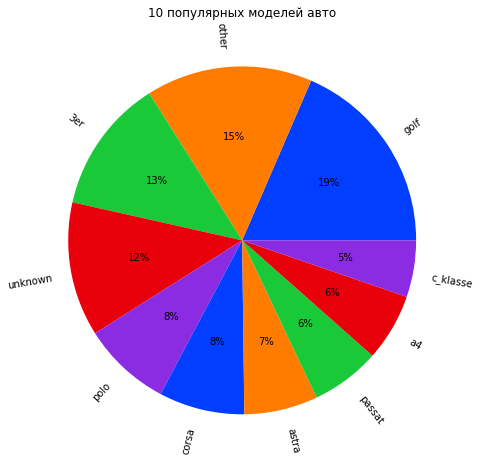

In [19]:
make_plot('model', '10 популярных моделей авто')

Самая популярная модель - Golf

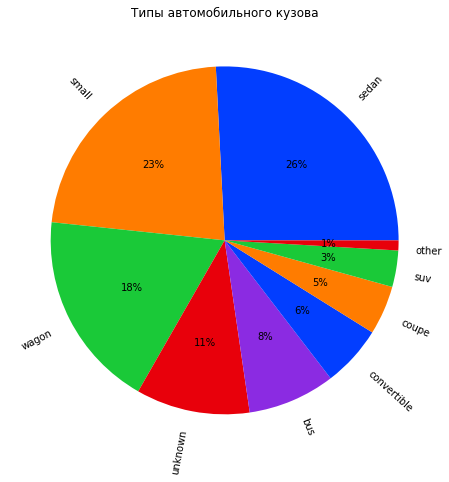

In [20]:
make_plot('vehicle_type', 'Типы автомобильного кузова')

Самый распространенный тип кузова - Седан

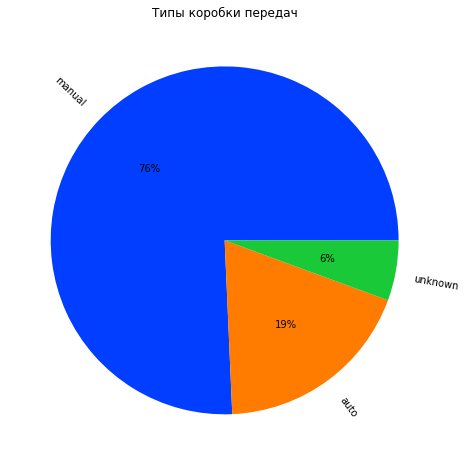

In [21]:
make_plot('gear_box', 'Типы коробки передач')

Большинство машин с ручной коробкой передач

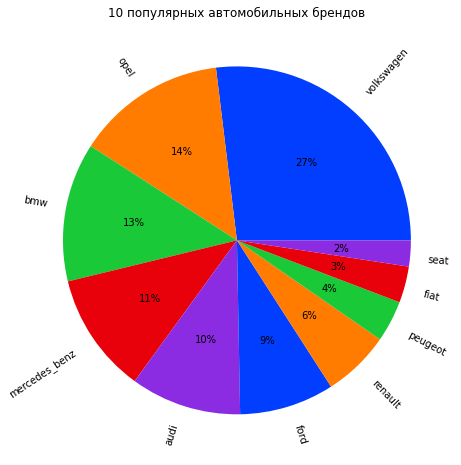

In [22]:
make_plot('brand', '10 популярных автомобильных брендов')

Среди брендов лидирует Volkswagen

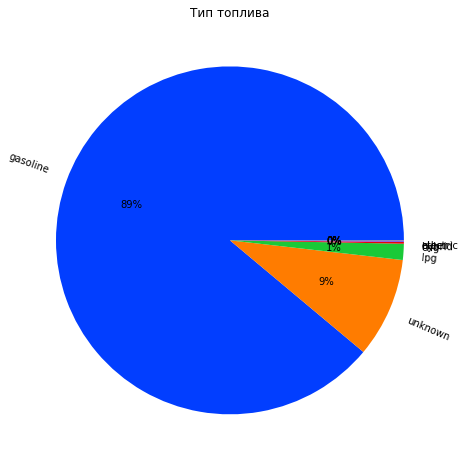

In [23]:
make_plot('fuel_type', 'Тип топлива')

Подавляющее большинство автомобилей используют в качестве топлива бензин

Посмотрим на распределение целевого признака price

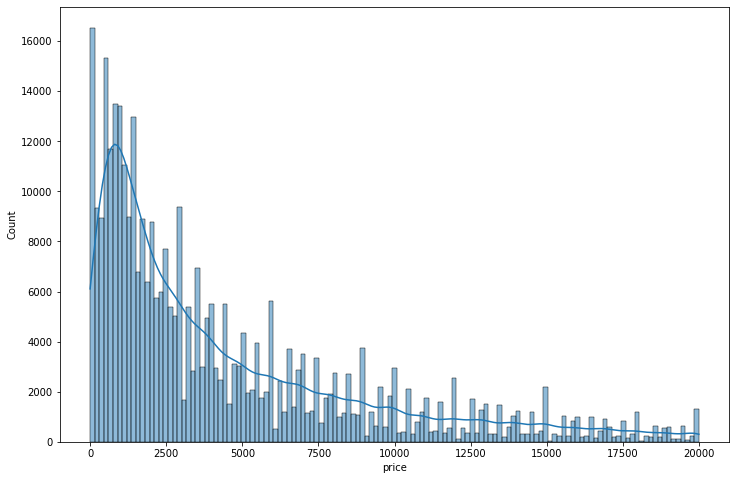

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=df['price'], kde = True)
plt.show()

In [25]:
cars_price_abnormal = df.query('price < 10')
cars_price_abnormal.shape

(12028, 11)

Стоимость более 12 тыс. автомобилей ниже 10€. Владельцы а/м могут указывать такую цену только за разбитый а/м под восставновление, либо с расчётом на равноценный обмен.
Удалим данные стоимости автомобилей ниже 10€, т.к. такие значения нам не интересны. 

In [26]:
df = df.query('price > 10')

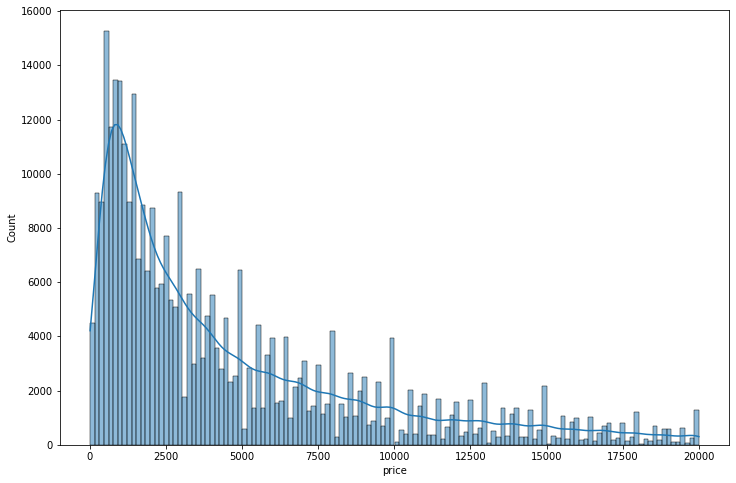

In [27]:
# Проверим, как изменилось распределение
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=df['price'], kde = True)
plt.show()

Посмотрим на значения в столбце power (мощность)

In [28]:
df['power'].describe()

count    342253.000000
mean        111.124943
std         188.194985
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

В данных много выбросов. Мощность автомобиля не может быть равна нулю. Согласно справочной информации, мощность серийных автомобилей не менее 50 л.с. и редко превышает 400 л.с. Посмотрим на распределение данных по квантилям от показателей столбца для графика.

Text(0, 0.5, 'Количество')

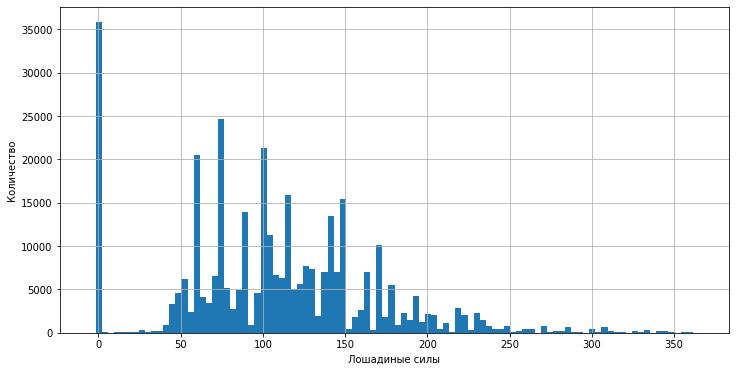

In [29]:
Q1 = df['power'].quantile(0.25)
Q3 = df['power'].quantile(0.75)
IQR = Q3 - Q1
fig, ax = plt.subplots()
df['power'].plot(kind = 'hist', bins = 100, grid = True, range = (Q1 - IQR, Q3 + 3*IQR), figsize = (12, 6))
ax.set_xlabel('Лошадиные силы')
ax.set_ylabel('Количество')

Согласно графику большинство автомобилей с мощностью до 350 лс. Примем это значение как максимум диапазона. Нулевые значения удалим.

In [30]:
df = df.query('0 < power < 350')

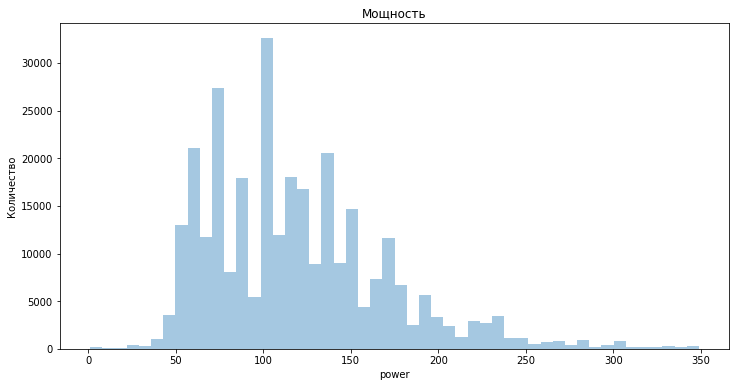

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Мощность')
sns.distplot(df['power'], kde=False, bins=50, ax = ax)
ax.set_ylabel('Количество')          
plt.show()

Посмотрим на данные в столбце registration_year

In [32]:
df['registration_year'].describe()

count    305299.000000
mean       2003.482458
std          29.172007
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

В данных есть выбросы. Годы выпуска 1000 и 9999 не могут соответствовать действительнсти. Посмотрим на распределение

In [33]:
df['registration_year'].describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99])

count    305299.000000
mean       2003.482458
std          29.172007
min        1000.000000
5%         1993.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
95%        2016.000000
99%        2017.000000
max        9999.000000
Name: registration_year, dtype: float64

Возьмем возьмем диапазон областей от 5% до 95% в столбце года регистрации.

In [34]:
df = df.query('registration_year >= 1993 and registration_year <= 2016')

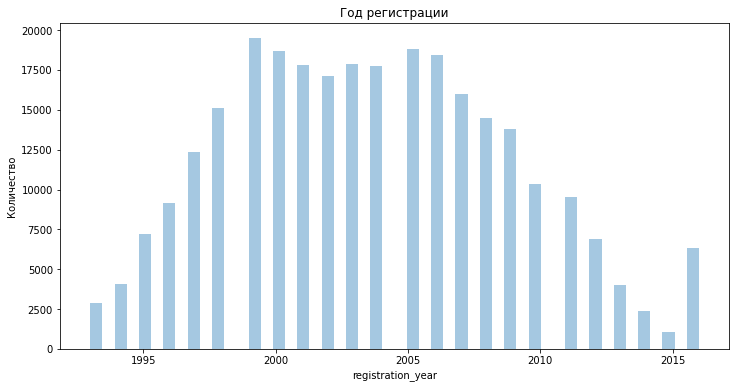

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Год регистрации')
sns.distplot(df['registration_year'], kde=False, bins=50, ax = ax)
ax.set_ylabel('Количество')          
plt.show()

Посмотрим на значения в столбце месяц регистрации (registration_month)

In [36]:
df['registration_month'].unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

In [37]:
df['registration_month'].value_counts()

3     28932
6     26211
4     24461
5     24406
7     22338
10    22133
12    20359
11    20210
9     20134
1     19123
8     18966
2     17990
0     16212
Name: registration_month, dtype: int64

В столбце появился 13-й месяц 0. Поскольку у нас 16212 нулевых значений, удалять их не будем. Этот параметр особого значения на ценообразование не имеет, заменим нулевые значения рандомными.

In [38]:
z = df['registration_month'].value_counts(normalize=True).drop(0)

df.loc[df["registration_month"] == 0, 'registration_month'] =  random.choices(
    z.index, weights=z, k=df.loc[df["registration_month"] == 0]['registration_month'].count())

In [39]:
# Проверим, что получилось
df['registration_month'].value_counts()

3     30765
6     27791
4     25973
5     25899
7     23665
10    23490
12    21612
11    21429
9     21397
1     20303
8     20110
2     19041
Name: registration_month, dtype: int64

Посмотрим, как изменились данные

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281475 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               281475 non-null  int64 
 1   vehicle_type        281475 non-null  object
 2   registration_year   281475 non-null  int64 
 3   gear_box            281475 non-null  object
 4   power               281475 non-null  int64 
 5   model               281475 non-null  object
 6   kilometer           281475 non-null  int64 
 7   registration_month  281475 non-null  int64 
 8   fuel_type           281475 non-null  object
 9   brand               281475 non-null  object
 10  repaired            281475 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.8+ MB


In [41]:
df.shape

(281475, 11)

In [42]:
df.head()

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,gasoline,bmw,yes


**ВЫВОД**

В результате предобработки данных:
- Мы потеряли около 20% данных, являющихся выбросами. Выбросы по каждому столбцы были проработаны и удалены. Причина такого количества выбросов, вероятнее всего, в человеческом факторе.
- Привели заголовки столбцов к змеиному регистру. 
- Пропуски заменили на unknown, дубликаты удалили.
- Удалили не информативные признаки, которые будут мешать обучению моделей и выполнению поставленной задачи.

## Обучение моделей

#### Подготовка к обучению

Выберем следующие регрессоры для обучения:

- LinearRegression
- DecisionTreeRegressor  
- RandomForestRegressor
- LGBMRegressor
- CatBoostRegressor

В качестве метрики для всех моделей будем использовать RMSE. 

Изменим тип данных object на category

In [43]:
for col in df.columns:
    if df[col].dtypes == 'object':
        df[col] = df[col].astype('category')

Подготовим данные для обучения, выделим целевой признак, разделим выборки на обучающую, вылидационную и тестовую  в соотношении 3:1:1 

In [44]:
features = df.drop(['price'], axis=1)
target = df['price']

X_train, X, y_train, y = train_test_split(features, target, 
                                            test_size=0.4, random_state=STATE)

X_test, X_valid, y_test, y_valid = train_test_split(X, y, 
                                           test_size=0.5, random_state=STATE)

In [45]:
# Проверим результат
X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_valid.shape, y_test.shape

((168885, 10), (56295, 10), (56295, 10), (168885,), (56295,), (56295,))

Подготовим списки с категориальными и числовыми значениями

In [46]:
cat = []
numeric = []
for col in features.columns:
    if features[col].dtypes == 'category':
        cat.append(col)
    else:
        numeric.append(col)

Для того, чтобы избежать появления значений Nan при использовании OrdinalEncoder, перезапишем индексы. 

In [48]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

Создадим словари гиперпараметров для моделей 

In [74]:
dt_params = {
    'max_depth': range(1, 15)
}
rf_params = {
    'n_estimators': range(10, 50, 5),
    'max_depth': range(5, 15, 3)
}
gbm_params = {
    'learning_rate': [0.2, 0.5],
    'n_estimators': range(20, 61, 20),
    'max_depth': range(10, 16, 5)
}
сbr_params = {
    'max_depth': range(10, 16, 5),
    'learning_rate': [0.2, 0.5],
    'iterations': [55, 60]
}

Напишем функцию для GridSearch

In [50]:
def Gsearch(model, params): 
    mod = GridSearchCV(
        model,
        param_grid = params,
        #scoring='neg_mean_squared_error',
        verbose=10,
        cv=5,
        n_jobs=-1, 
    )
    return mod

Определим функцию для подсчета RMSE

In [51]:
def rmse(target, predicted):
    rmse = mean_squared_error(target, predicted)**0.5
    return rmse

Построим препроцессинг для Pipeline

In [52]:
# Будем использовать технику OheНоtEncoder для модели линейной регрессии и OrdinalEncoder для "деревянных" моделей 

ohe = OneHotEncoder(handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 
ss = StandardScaler()

In [53]:
ohe_cat_pipe = Pipeline([
    ('ohe', ohe)
])
oe_cat_pipe = Pipeline([('oe', oe)
])
num_pipe = Pipeline([
    ('ss', ss)
    
])

In [54]:
ohe_preprocessor = ColumnTransformer([
    ('cat', ohe_cat_pipe, cat),
    ('numeric', num_pipe, numeric)
])    
oe_preprocessor = ColumnTransformer([
    ('cat', oe_cat_pipe, cat),
    ('numeric', num_pipe, numeric)
])  

#### Линейная регрессия

In [55]:
pipe = Pipeline([
    ('preprocessor', ohe_preprocessor),
    ('model', LinearRegression())
])

start = time.time()
pipe.fit(X_train, y_train)
end = time.time()
time_fit_lr = end - start

start = time.time()
y_train_pred = pipe.predict(X_valid)
end = time.time()
time_pred_lr = end - start

RMSE = rmse(y_valid, y_train_pred)

print('RMSE для линейной регресии равен:', RMSE)
print('Время обучения линейной регрессии:', time_fit_lr)
print('Время предсказания линейной регрессии:', time_pred_lr)

#### Дерево решений

In [56]:
pipe = Pipeline([
    ('preprocessor', oe_preprocessor),
    ('model', Gsearch(DecisionTreeRegressor(random_state=STATE), dt_params))
])

start = time.time()
pipe.fit(X_train, y_train)
end = time.time()
time_fit_dt = end - start

start = time.time()
y_train_pred = pipe.predict(X_valid)
end = time.time()
time_pred_dt = end - start

RMSE = rmse(y_valid, y_train_pred)

print('RMSE для дерева решений равен:', RMSE)
print('Время обучения дерева решений:', time_fit_dt)
print('Время предсказания дерева решений:', time_pred_dt)

#### Случайный лес

In [57]:
pipe = Pipeline([
    ('preprocessor', oe_preprocessor),
    ('model', Gsearch(RandomForestRegressor(random_state=STATE), rf_params))
])

start = time.time()
pipe.fit(X_train, y_train)
end = time.time()
time_fit_rf = end - start

start = time.time()
y_train_pred = pipe.predict(X_valid)
end = time.time()
time_pred_rf = end - start

RMSE = rmse(y_valid, y_train_pred)


print('RMSE для случайного леса равен:', RMSE)
print('Время обучения случайного леса:', time_fit_rf)
print('Время предсказания случайного леса:', time_pred_rf)

#### Библиотеки для градиентного бустинга


**LightGBM**

In [58]:
pipe = Pipeline([
    ('preprocessor', oe_preprocessor),
    ('model', Gsearch(LGBMRegressor(random_state=STATE), gbm_params))
])

start = time.time()
pipe.fit(X_train, y_train)
end = time.time()
time_fit_gbm = end - start

start = time.time()
y_train_pred = pipe.predict(X_valid)
end = time.time()
time_pred_gbm = end - start

RMSE = rmse(y_valid, y_train_pred)

print('RMSE для LightGBM:', RMSE)
print('Время обучения LightGBM:', time_fit_gbm)
print('Время предсказания LightGBM:', time_pred_gbm)

**CatBoostRegressor**

Для библиотеки CatBoostRegressor использованы два метода, с пайплайном и Гридсерч. Оба дали абсолютно одинаковые результаты по предсказаниям. Однако с пайплайном модель дольше обучалась, но чуть быстрее предсказывала (на 0,01 с). Для анализа модели взяты результаты Гридсерч

In [66]:
pipe = Pipeline([
    ('model', Gsearch(CatBoostRegressor(loss_function='RMSE', cat_features=cat, random_state=12345), cbr_params))
])


start = time.time()
pipe.fit(X_train, y_train)
end = time.time()
time_fit_cbr = end - start

start = time.time()
y_train_pred = pipe.predict(X_valid)
end = time.time()
time_pred_cbr = end - start

RMSE = rmse(y_valid, y_train_pred)

print('RMSE для CatBoostRegressor:', RMSE)
print('Время обучения CatBoostRegressor:', time_fit_cbr)
print('Время предсказания CatBoostRegressor:', time_pred_cbr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START iterations=55, learning_rate=0.2, max_depth=10..............
0:	learn: 3916.1435767	total: 81.2ms	remaining: 4.39s
1:	learn: 3402.3108503	total: 167ms	remaining: 4.42s
2:	learn: 3009.3373218	total: 237ms	remaining: 4.1s
3:	learn: 2710.8645054	total: 317ms	remaining: 4.04s
4:	learn: 2491.2303714	total: 394ms	remaining: 3.94s
5:	learn: 2295.7528312	total: 474ms	remaining: 3.87s
6:	learn: 2155.8369507	total: 566ms	remaining: 3.88s
7:	learn: 2058.0452113	total: 657ms	remaining: 3.86s
8:	learn: 1968.8681308	total: 740ms	remaining: 3.78s
9:	learn: 1901.5810298	total: 820ms	remaining: 3.69s
10:	learn: 1851.3863992	total: 897ms	remaining: 3.59s
11:	learn: 1816.0872065	total: 980ms	remaining: 3.51s
12:	learn: 1785.4490377	total: 1.06s	remaining: 3.43s
13:	learn: 1757.0290860	total: 1.14s	remaining: 3.33s
14:	learn: 1729.1018251	total: 1.21s	remaining: 3.23s
15:	learn: 1711.1092290	total: 1.29s	remaining: 3.15s
16:	l

In [68]:
cbr = CatBoostRegressor(loss_function='RMSE', cat_features=cat, random_state=12345)
cbr_params = {'max_depth': range(10, 16, 5), 'learning_rate': [0.2, 0.5], 'iterations': [55, 60]}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_squared_error')

grid_cbr.fit(X_train, y_train);

grid_cbr.best_params_

0:	learn: 3916.0467359	total: 70.7ms	remaining: 3.82s
1:	learn: 3411.2737681	total: 135ms	remaining: 3.57s
2:	learn: 3016.2318393	total: 203ms	remaining: 3.52s
3:	learn: 2720.4549287	total: 277ms	remaining: 3.53s
4:	learn: 2504.1404040	total: 345ms	remaining: 3.44s
5:	learn: 2308.0561474	total: 411ms	remaining: 3.35s
6:	learn: 2166.1412775	total: 471ms	remaining: 3.23s
7:	learn: 2061.4955012	total: 536ms	remaining: 3.15s
8:	learn: 1973.2411512	total: 597ms	remaining: 3.05s
9:	learn: 1905.8971491	total: 657ms	remaining: 2.96s
10:	learn: 1857.7075057	total: 727ms	remaining: 2.91s
11:	learn: 1816.5073300	total: 790ms	remaining: 2.83s
12:	learn: 1788.5497254	total: 851ms	remaining: 2.75s
13:	learn: 1754.4309886	total: 915ms	remaining: 2.68s
14:	learn: 1730.6721492	total: 976ms	remaining: 2.6s
15:	learn: 1711.1528448	total: 1.05s	remaining: 2.56s
16:	learn: 1695.4236801	total: 1.11s	remaining: 2.48s
17:	learn: 1682.5036056	total: 1.17s	remaining: 2.4s
18:	learn: 1671.0753590	total: 1.23s	re

{'iterations': 60, 'learning_rate': 0.2, 'max_depth': 15}

In [65]:
model_cbr = grid_cbr.best_estimator_
start = time.time()
model_cbr.fit(X_train, y_train)
end = time.time()
time_fit_cbr = end - start

start = time.time()
pred = model_cbr.predict(X_valid)
end = time.time()
time_pred_cbr = end - start

RMSE = rmse(y_valid, pred)

print('RMSE для CatBoostRegressor:', RMSE)
print('Время обучения CatBoostRegressor:', time_fit_cbr)
print('Время предсказания CatBoostRegressor:', time_pred_cbr)

0:	learn: 3910.7300777	total: 266ms	remaining: 15.7s
1:	learn: 3368.4934837	total: 808ms	remaining: 23.4s
2:	learn: 2985.4107460	total: 915ms	remaining: 17.4s
3:	learn: 2678.6833623	total: 1.46s	remaining: 20.5s
4:	learn: 2443.0559113	total: 2.02s	remaining: 22.3s
5:	learn: 2240.3856529	total: 2.6s	remaining: 23.4s
6:	learn: 2082.1886963	total: 3.18s	remaining: 24.1s
7:	learn: 1966.0446728	total: 3.75s	remaining: 24.4s
8:	learn: 1869.0315652	total: 4.32s	remaining: 24.5s
9:	learn: 1799.6720866	total: 4.87s	remaining: 24.3s
10:	learn: 1745.8356402	total: 5.4s	remaining: 24.1s
11:	learn: 1707.3531548	total: 5.97s	remaining: 23.9s
12:	learn: 1676.9048303	total: 6.51s	remaining: 23.5s
13:	learn: 1651.1323181	total: 7.04s	remaining: 23.1s
14:	learn: 1618.3566470	total: 7.61s	remaining: 22.8s
15:	learn: 1591.2127974	total: 8.18s	remaining: 22.5s
16:	learn: 1570.0445248	total: 8.74s	remaining: 22.1s
17:	learn: 1554.5700693	total: 9.29s	remaining: 21.7s
18:	learn: 1540.2302533	total: 9.82s	rem

## Анализ моделей

Соберем показатели и выведем на экран

**РЕМАРКА**. 
*Из-за крайне низкой скорости работы тренажера мне пришлось вручную собирать данные в таблицу, так как все модели запускаю по очереди, закомментировав остальные. Правильнее было бы собрать показатели в пустой список и добавлять по мере обучения и предсказания новых*

In [67]:
results = {
    'Model' : ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor',
               'LGBMRegressor', 'CatBoostRegressor'],
    'Model_RMSE' :pd.Series([2256.10, 1768.73, 1567.14, 1549.29, 1501.77]),
    'Train Time': pd.Series([19.81, 14.95, 735.84, 273.39, 33.60]),
    'Predict Time': pd.Series([0.19, 0.09, 0.43, 0.30, 0.06])
    }

display(pd.DataFrame(results))

,Model,Model_RMSE,Train Time,Predict Time
0,LinearRegression,2256.10,19.81,0.19
1,DecisionTreeRegressor,1768.73,14.95,0.09
2,RandomForestRegressor,1567.14,735.84,0.43
3,LGBMRegressor,1549.29,273.39,0.30
4,CatBoostRegressor,1501.77,33.60,0.06


**ВЫВОД**

По качеству предсказания лидируют библиотеки градиентного бустинга.  
Сравнивая результаты моделей LGBMRegressor и CatBoostRegressor, видим, что по всем параметрам CatBoostRegressor покказывает лучшие значения.  
Из обычных моделей более точная RandomForestRegressor, по скорости лидирует LinearRegression 

Проверим модель CatBoostRegressor на тестовой выборке, используя лучшие гиперпараметры

In [69]:
best_model = grid_cbr.best_estimator_

best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)

RMSE = rmse(y_test, pred)

print('RMSE CatBoostRegressor на тестовой выборке:', RMSE)

0:	learn: 3896.1128869	total: 529ms	remaining: 31.2s
1:	learn: 3368.5239608	total: 1.08s	remaining: 31.3s
2:	learn: 2970.7525296	total: 1.55s	remaining: 29.4s
3:	learn: 2655.8616626	total: 2.11s	remaining: 29.6s
4:	learn: 2430.0440346	total: 2.64s	remaining: 29s
5:	learn: 2218.4956113	total: 3.19s	remaining: 28.7s
6:	learn: 2065.6442928	total: 3.74s	remaining: 28.3s
7:	learn: 1954.4227691	total: 4.29s	remaining: 27.9s
8:	learn: 1855.9953896	total: 4.84s	remaining: 27.4s
9:	learn: 1787.3907382	total: 5.37s	remaining: 26.9s
10:	learn: 1733.9432950	total: 5.91s	remaining: 26.3s
11:	learn: 1693.7788503	total: 6.45s	remaining: 25.8s
12:	learn: 1663.3903819	total: 7s	remaining: 25.3s
13:	learn: 1639.5500834	total: 7.53s	remaining: 24.7s
14:	learn: 1606.1830864	total: 8.07s	remaining: 24.2s
15:	learn: 1577.4476482	total: 8.64s	remaining: 23.8s
16:	learn: 1560.3332123	total: 9.2s	remaining: 23.3s
17:	learn: 1544.2980570	total: 9.74s	remaining: 22.7s
18:	learn: 1530.6344163	total: 10.3s	remaini

Результат предсказаний модели на тестовой выборке улучшился на 0,73%

Проверим модель на адекватность

In [72]:
dummy_clf = DummyRegressor(strategy="mean")
dummy_clf.fit(X_train, y_train)
DummyRegressor(strategy='most_frequent')
test_model_prediction = dummy_clf.predict(X_test)
RMSE = mean_squared_error(y_test, test_model_prediction, squared=False)

print('RMSE на DummyRegressor равен:', RMSE)

RMSE на DummyRegressor равен: 4602.823141758425


Результат более, чем в три раза превышает полученный. Модель адекватна

**ВЫВОД**. 

По условию задачи заказчику важны: 
1. качество предсказания; 
2. скорость предсказания; 
3. время обучения.

По результатам проведенного исследования мы рекомендуем отдать предпочтение CatBoostRegressor, так как модель имеет лучшее качество предсказания и выигрывает в скорости предсказания.
Линейные же модели обладают большей скоростью предсказания, но плохим качеством, а значит не подходят для нашей задачи.